<a href="https://colab.research.google.com/github/nandhukumar86/CapstonePneumoniaDetection/blob/main/DenseNet_TransferLearning_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline
import cv2
import skimage.io as io
import os
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, Concatenate, Reshape, UpSampling2D
import pickle
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.losses import binary_crossentropy
import gc
from tensorflow.keras.applications import DenseNet121, DenseNet201
from tensorflow.keras.applications import VGG16
from google.colab.patches import cv2_imshow
from tensorflow import reduce_sum
from tensorflow.keras.backend import log,epsilon

from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file = open('/content/drive/MyDrive/CapstoneDataSet/dataset/RezisedLabel-1.pickle', 'rb')
dfData = pickle.load(file)
file.close()

In [5]:
def dice_coefficient(y_true, y_pred):
  numerator = 2 * reduce_sum(y_true * y_pred)
  denominator = reduce_sum(y_true + y_pred)

  return numerator / (denominator + epsilon())


def loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [6]:
dfData_0 = dfData[dfData['Target'] == 0].sample(9555)
dfData_1 = dfData[dfData['Target'] == 1].sample(9555)

In [7]:
dfData = pd.concat([dfData_0, dfData_1], axis=0, ignore_index=True)

In [8]:
dfData = dfData.sample(frac=1)

In [9]:
y = []
y_classifier = []
X = []
i = 0
for pId in dfData['patientId'].unique():
  data = dfData[dfData['patientId'] == pId][['Image256','xo','yo','widtho','heighto','Target']]
  X.append(cv2.cvtColor(cv2.resize(data.iloc[0][0],(256,256)), cv2.COLOR_BAYER_GR2RGB))
  mask = np.zeros((256,256))
  if (data.iloc[0][5] == 1):
    j = 0
    for segment in range(data.shape[0]):
      xo = int(data.iloc[j][1])
      yo = int(data.iloc[j][2])
      wo = int(data.iloc[j][1] + data.iloc[j][3])
      ho = int(data.iloc[j][2] + data.iloc[j][4])
      mask = cv2.rectangle(mask,(xo, yo),(wo, ho),(255,0,0),-1)
      mask = cv2.resize(mask,(32,32))
      j = j+1
  y.append(cv2.resize(mask,(8,8)))
  y_classifier.append(data.iloc[0][5])
  if (i%1000 == 0):
    print(i, " completed")
  # if (i==9999):
  #   break;
  i = i + 1

0  completed
1000  completed
2000  completed
3000  completed
4000  completed
5000  completed
6000  completed
7000  completed
8000  completed
9000  completed
10000  completed
11000  completed
12000  completed
13000  completed
14000  completed
15000  completed


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=100)

X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X, y_classifier, test_size=0.30, random_state=100)

In [11]:
tensorflow.keras.backend.clear_session()

In [12]:
gc.collect()

237

In [52]:
model = DenseNet201(input_shape=(256,256,3),include_top=False,weights='imagenet')

In [53]:
lengthLayers = len(model.layers)
pcLayers = int(0.90 * lengthLayers)
for i in range(pcLayers):
  model.layers[i].trainable = False
  

In [54]:
layer8x8 = model.get_layer('conv5_block32_2_conv').output

y = Flatten()(layer8x8)
y = Dense(1, activation='sigmoid')(y)
model_classifier = Model(model.input, y)

In [16]:
gc.collect()

50

In [39]:
X_train_c = preprocess_input(np.array(X_train_c))
y_train_c = np.array(y_train_c)
X_val_c = preprocess_input(np.array(X_val_c))
y_val_c = np.array(y_val_c)

In [40]:
gc.collect()

176

In [41]:
model_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

earlystop_classifier = tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2, min_delta=0.01)

model_classifier.fit(X_train_c, y_train_c, epochs=5, batch_size=32, validation_data=(X_val_c, y_val_c), verbose=1) 


Epoch 1/5
341/341 [==============================] - 70s 172ms/step - loss: 0.4737 - accuracy: 0.7747 - val_loss: 0.4397 - val_accuracy: 0.7938
Epoch 2/5
341/341 [==============================] - 54s 160ms/step - loss: 0.4267 - accuracy: 0.8001 - val_loss: 0.4500 - val_accuracy: 0.7913
Epoch 3/5
341/341 [==============================] - 54s 160ms/step - loss: 0.3831 - accuracy: 0.8268 - val_loss: 0.4688 - val_accuracy: 0.7808
Epoch 4/5
341/341 [==============================] - 54s 160ms/step - loss: 0.2992 - accuracy: 0.8743 - val_loss: 0.5857 - val_accuracy: 0.7594
Epoch 5/5
341/341 [==============================] - 55s 161ms/step - loss: 0.1822 - accuracy: 0.9279 - val_loss: 0.7057 - val_accuracy: 0.7457


In [42]:
! pip install tensorflowjs

In [43]:
import tensorflowjs
tensorflowjs.converters.save_keras_model(model_classifier,'/content/drive/MyDrive/CapstoneDataSet/classificationModel')

In [17]:
gc.collect()

50

In [18]:
yy = Conv2D(1, kernel_size = 1)(layer8x8)
model_image = Model(model.input, yy)

In [19]:
X_train = preprocess_input(np.array(X_train))
y_train = np.array(y_train)/255
X_val = preprocess_input(np.array(X_val))
y_val = np.array(y_val)/255

In [21]:
model_image.compile(optimizer='adam', loss=loss, metrics=[dice_coefficient])

earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor='dice_coefficient', patience=5, min_delta=0.01)

model_image.fit(X_train, y_train, epochs=5, batch_size=16, verbose=1, validation_data=(X_val, y_val), callbacks=[earlystop]) 

Epoch 1/5
681/681 [==============================] - 92s 99ms/step - loss: 1.3515 - dice_coefficient: 0.3282 - val_loss: 1.2706 - val_dice_coefficient: 0.3470
Epoch 2/5
681/681 [==============================] - 64s 94ms/step - loss: 1.1903 - dice_coefficient: 0.3671 - val_loss: 1.2133 - val_dice_coefficient: 0.3653
Epoch 3/5
681/681 [==============================] - 64s 94ms/step - loss: 1.1589 - dice_coefficient: 0.3779 - val_loss: 1.2201 - val_dice_coefficient: 0.3616
Epoch 4/5
681/681 [==============================] - 64s 94ms/step - loss: 1.0951 - dice_coefficient: 0.4003 - val_loss: 1.2213 - val_dice_coefficient: 0.3658
Epoch 5/5
681/681 [==============================] - 65s 95ms/step - loss: 1.0546 - dice_coefficient: 0.4130 - val_loss: 1.2240 - val_dice_coefficient: 0.3630


In [24]:
import tensorflowjs
tensorflowjs.converters.save_keras_model(model_image,'/content/drive/MyDrive/CapstoneDataSet/segmentModel')

In [26]:
y_test_predict = model_image.predict(X_val)
# y_train_predict = model.predict(X_train)


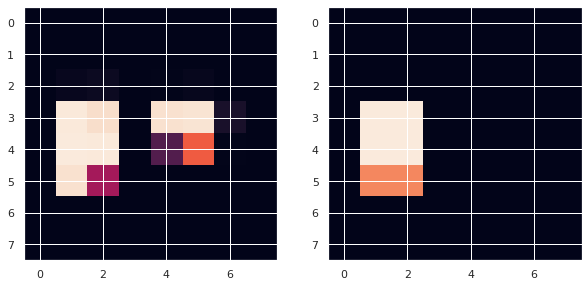

In [51]:
n = 401

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(y_test_predict[n].reshape(8,8))
axes[1].imshow(y_val[n]);


In [48]:
y_val[n]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.75, 0.75, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])